# Word2Vec training

This notebook is based on the [word2vec-pytorch](https://github.com/OlgaChernytska/word2vec-pytorch/tree/18d4f24c4d82dde76de9f6e4d88bbcbcf68befc2) repo.

In [ ]:
%%bash
mkdir wikitext-2
wget https://huggingface.co/datasets/wikitext/resolve/main/wikitext-2-v1/train-00000-of-00001.parquet?download=true -O wikitext-2/train.parquet
wget https://huggingface.co/datasets/wikitext/resolve/main/wikitext-2-v1/validation-00000-of-00001.parquet?download=true -O wikitext-2/valid.parquet

In [ ]:
import pandas as pd

train = pd.read_parquet('wikitext-2/train.parquet')
train.to_csv(r'wikitext-2/wiki.train.tokens', header=None, index=None, sep=' ', mode='a')
valid = pd.read_parquet('wikitext-2/valid.parquet')
valid.to_csv(r'wikitext-2/wiki.valid.tokens', header=None, index=None, sep=' ', mode='a')

In [1]:
import torchtext

assert torchtext.__version__ == '0.6.0'

In [2]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

In [3]:
TRAIN_TOKENS = 'wikitext-2/wiki.train.tokens'
VALID_TOKENS = 'wikitext-2/wiki.valid.tokens'

SKIPGRAM_N_WORDS = 4
MIN_WORD_FREQUENCY = 20
MAX_SEQUENCE_LENGTH = 256

EMBED_DIM = 256
EMBED_MAX_NORM = 1
BATCH_SIZE = 128

In [4]:
tokenizer = get_tokenizer("basic_english", language="en")

def load_and_preprocess_dataset(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    data = list(filter(
        lambda sent: len(sent) > SKIPGRAM_N_WORDS * 2,
        map(tokenizer, lines)
    ))
    return data

In [5]:
train_data = load_and_preprocess_dataset(TRAIN_TOKENS)
valid_data = load_and_preprocess_dataset(VALID_TOKENS)

total_train_tokens = sum(len(sent) for sent in train_data)
total_valid_tokens = sum(len(sent) for sent in valid_data)

print(f'Num sentences: train - {len(train_data)}, valid - {len(valid_data)}')
print(f'Total tokens: train - {total_train_tokens}, valid - {total_valid_tokens}')
print(f'Average tokens in sentence: {total_train_tokens / len(train_data):.2f}')

Num sentences: train - 35430, valid - 1892
Total tokens: train - 4028676, valid - 211057
Average tokens in sentence: 113.71


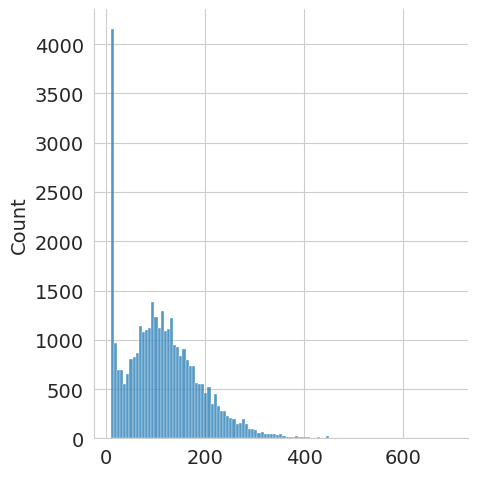

In [6]:
_ = sns.displot([len(sent) for sent in train_data])

In [7]:
counter = Counter(token for sent in train_data for token in sent)

In [8]:
len(counter)

28771

In [9]:
vocab = Vocab(counter, min_freq=MIN_WORD_FREQUENCY, specials=['<unk>'])

VOCAB_SIZE = len(vocab)
print(f'Vocab size: {VOCAB_SIZE}')

Vocab size: 12860


In [10]:
train_data[102]

['seaside', 'holiday', 'j', '.', 'salmon', ',', '1918', ',', '1921']

In [11]:
[vocab[token] for token in train_data[102]]

[0, 3041, 1415, 3, 4855, 2, 2079, 2, 3157]

In [12]:
def sent_to_idx(sent):
    return [vocab[token] for token in sent]


def collate_fn(batch):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = sent_to_idx(text)

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            batch_input += [input_] * len(outputs)
            batch_output += outputs

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

In [13]:
out = collate_fn(train_data[4:8])

In [14]:
out[0].shape, out[1].shape

(torch.Size([5688]), torch.Size([5688]))

In [15]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4,
                          pin_memory=True, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4,
                          pin_memory=True, collate_fn=collate_fn)

In [16]:
from IPython.display import clear_output
from tqdm.notebook import tqdm


def plot_losses(train_losses, valid_losses):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='valid', color='springgreen', linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [17]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, num_batches = 0.0, 1
    model.train()
    for inputs, pos_outputs in tqdm(train_loader, desc=tqdm_desc):
        inputs = inputs.to(device)
        pos_outputs = pos_outputs.to(device)
        neg_outputs = torch.randint_like(inputs, low=0, high=VOCAB_SIZE)

        input_emb = model.encoder(inputs)
        pos_output_emb = model.decoder(pos_outputs)
        neg_output_emb = model.decoder(neg_outputs)

        optimizer.zero_grad()
        pos_sim = (input_emb * pos_output_emb).sum(1)
        neg_sim = (input_emb * neg_output_emb).sum(1)

        loss = criterion(pos_sim, torch.ones(pos_sim.shape, device=device)) + \
               criterion(neg_sim, torch.zeros(neg_sim.shape, device=device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_batches += 1

    train_loss /= num_batches
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss, num_batches = 0.0, 0
    model.eval()
    for inputs, pos_outputs in tqdm(valid_loader, desc=tqdm_desc):
        inputs = inputs.to(device)
        pos_outputs = pos_outputs.to(device)
        neg_outputs = torch.randint_like(inputs, low=0, high=VOCAB_SIZE)

        input_emb = model.encoder(inputs)
        pos_output_emb = model.decoder(pos_outputs)
        neg_output_emb = model.decoder(neg_outputs)

        pos_sim = (input_emb * pos_output_emb).sum(1)
        neg_sim = (input_emb * neg_output_emb).sum(1)

        loss = criterion(pos_sim, torch.ones(pos_sim.shape, device=device)) + \
               criterion(neg_sim, torch.zeros(neg_sim.shape, device=device))

        valid_loss += loss.item()
        num_batches += 1

    valid_loss /= num_batches
    return valid_loss


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    train_losses, valid_losses = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses)

In [18]:
class Word2VecModel(nn.Module):
    def __init__(self, embed_dim, embed_max_norm, vocab_size):
        super().__init__()
        self.encoder = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim,
                                    max_norm=embed_max_norm)
        self.decoder = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [20]:
NUM_EPOCHS = 20
model = Word2VecModel(embed_dim=EMBED_DIM, embed_max_norm=EMBED_MAX_NORM,
                      vocab_size=VOCAB_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = nn.BCEWithLogitsLoss()

In [21]:
sum(param.numel() for param in model.parameters())

6584320

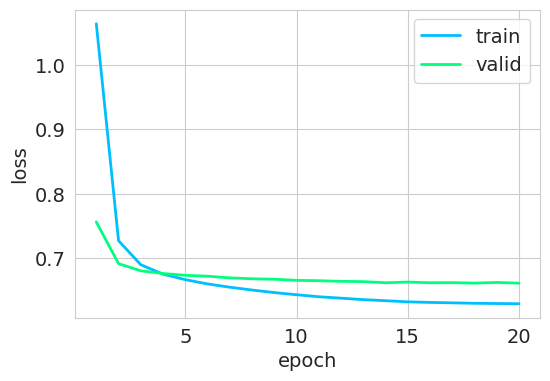

In [22]:
train(model, optimizer, scheduler, criterion, train_loader, valid_loader, NUM_EPOCHS)

In [30]:
import re


def get_similarities(embed_vector):
    similarities = embed_matrix @ embed_vector / embed_norms / torch.norm(embed_vector)
    top_indices = similarities.argsort(descending=True)
    return similarities, top_indices


def get_similar(query, num_similar=5):
    print(f'Processing query \"{query}\"')
    split_query = re.split('([^a-zA-Z0-9])', query)
    index = vocab[split_query[0]]
    embed_vector = torch.clone(embed_matrix[index])
    if index > 0:
        print(f'Found word \"{split_query[0]}\" in vocab')
    else:
        print(f'Word \"{split_query[0]}\" not in vocab, using <unk>')

    for i in range(2, len(split_query), 2):
        index = vocab[split_query[i]]
        if index > 0:
            print(f'Found word \"{split_query[i]}\" in vocab, ', end='')
        else:
            print(f'Word \"{split_query[i]}\" not in vocab, using <unk>, ', end='')
        print(f'operation \"{split_query[i - 1]}\"')

        if split_query[i - 1] == '+':
            embed_vector += embed_matrix[index]
        elif split_query[i - 1] == '-':
            embed_vector -= embed_matrix[index]
        else:
            raise ValueError('Unknown operation')

    similarities, top_indices = get_similarities(embed_vector)
    print('Top similar:')
    for top_index in top_indices[:num_similar]:
        print(f'    {vocab.itos[top_index]}: sim = {similarities[top_index]:.4f}')

In [31]:
embed_matrix = model.encoder.weight.detach()
embed_norms = (embed_matrix ** 2).sum(1).sqrt()

In [32]:
get_similar('woman')

Processing query "woman"
Found word "woman" in vocab
Top similar:
    woman: sim = 1.0000
    her: sim = 0.7443
    who: sim = 0.7239
    you: sim = 0.7189
    she: sim = 0.7143


In [33]:
get_similar('s', num_similar=10)

Processing query "s"
Found word "s" in vocab
Top similar:
    s: sim = 1.0000
    ': sim = 0.9774
    his: sim = 0.8705
    <unk>: sim = 0.8255
    ,: sim = 0.8140
    was: sim = 0.8111
    her: sim = 0.8073
    who: sim = 0.8037
    he: sim = 0.8024
    .: sim = 0.7971


In [34]:
get_similar('kick')

Processing query "kick"
Found word "kick" in vocab
Top similar:
    kick: sim = 1.0000
    penalty: sim = 0.6607
    yard: sim = 0.6547
    punt: sim = 0.6541
    18-: sim = 0.6411


In [35]:
get_similar('help')

Processing query "help"
Found word "help" in vocab
Top similar:
    help: sim = 1.0000
    would: sim = 0.7528
    not: sim = 0.7363
    them: sim = 0.7339
    to: sim = 0.7338


In [36]:
v = get_similar('queen-woman+man', num_similar=10)

Processing query "queen-woman+man"
Found word "queen" in vocab
Found word "woman" in vocab, operation "-"
Found word "man" in vocab, operation "+"
Top similar:
    queen: sim = 0.7614
    man: sim = 0.6579
    anne: sim = 0.5100
    <unk>: sim = 0.4999
    shortly: sim = 0.4989
    took: sim = 0.4955
    was: sim = 0.4932
    richardson: sim = 0.4929
    helms: sim = 0.4885
    farley: sim = 0.4876
